<a href="https://colab.research.google.com/github/lindsay99m/GEO-558-EDA/blob/main/lmoller_first_pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

I will be using earthquake data from the Northern California Earthquake Data Center. This data contains information on
magnitude, depth, time, date, location, etc. for earthquakes in Northern California. I will use this data to attempt to determine if there is a
correlation between earthquake magnitude, location, and intervals between earthquakes. I am using data from the year 2019. The dataset is localized to a fairly small area which will hoepfully make it easier to determine if there is a correlation between the recorded earthquake data.

In [65]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
url = 'https://raw.githubusercontent.com/lindsay99m/GEO-558-EDA/a3be2ff5451bb313c79175cd17fe8ccb440f97d6/NCEDCdata.csv'
data = pd.read_csv(url)
data.describe()

,Lat,Lon,Depth,Mag,Nst,Gap,Clo,RMS,Event ID
count,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2.799000e+03
mean,37.226104,-119.995539,6.486720,2.512176,30.489461,119.868882,14.202572,0.131597,7.322216e+07
std,1.649315,2.318310,7.328887,0.445542,26.466518,67.518041,17.008724,0.158346,1.313775e+05
min,34.519330,-125.910160,-2.250000,2.000000,4.000000,16.000000,0.000000,0.000000,7.111009e+07
25%,36.089670,-122.009750,1.690000,2.190000,9.000000,69.000000,3.000000,0.060000,7.318831e+07
50%,36.431000,-118.874500,4.750000,2.410000,23.000000,104.000000,9.000000,0.090000,7.322798e+07
75%,38.757000,-117.890500,8.750000,2.700000,45.000000,159.000000,19.000000,0.140000,7.327119e+07
max,41.891170,-117.760170,55.650000,5.580000,245.000000,352.000000,160.000000,2.580000,7.332190e+07


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2799 non-null   object 
 1   Time           2799 non-null   object 
 2        Lat       2799 non-null   float64
 3          Lon     2799 non-null   float64
 4    Depth         2799 non-null   float64
 5    Mag           2799 non-null   float64
 6   Magt           2799 non-null   object 
 7   Nst            2799 non-null   float64
 8   Gap            2799 non-null   float64
 9   Clo            2799 non-null   float64
 10   RMS           2799 non-null   float64
 11   SRC           2799 non-null   object 
 12  Event ID       2799 non-null   float64
dtypes: float64(9), object(4)
memory usage: 284.5+ KB


In [67]:
data.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Date,Time,Lat,Lon,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,Event ID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019/01/01,06:33:03.59,35.87267,-121.41167,9.16,2.22,Md,38.0,190.0,22.0,0.07,NCSN,73129046.0
2,2019/01/01,08:16:00.70,37.97066,-122.34917,4.96,2.28,Md,92.0,18.0,4.0,0.16,NCSN,73129051.0
3,2019/01/01,13:58:08.02,37.30700,-120.00317,15.86,2.10,Md,11.0,141.0,26.0,0.15,NCSN,73129111.0
4,2019/01/01,22:59:54.86,40.88700,-123.47767,22.66,3.26,ML,85.0,30.0,22.0,0.18,NCSN,73129211.0


In [68]:
#remove empty row
data = data.drop(index=0)

In [69]:
data.head()

,Date,Time,Lat,Lon,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,Event ID
1,2019/01/01,06:33:03.59,35.87267,-121.41167,9.16,2.22,Md,38.0,190.0,22.0,0.07,NCSN,73129046.0
2,2019/01/01,08:16:00.70,37.97066,-122.34917,4.96,2.28,Md,92.0,18.0,4.0,0.16,NCSN,73129051.0
3,2019/01/01,13:58:08.02,37.30700,-120.00317,15.86,2.10,Md,11.0,141.0,26.0,0.15,NCSN,73129111.0
4,2019/01/01,22:59:54.86,40.88700,-123.47767,22.66,3.26,ML,85.0,30.0,22.0,0.18,NCSN,73129211.0
5,2019/01/01,23:36:16.51,38.80700,-122.82317,1.14,2.07,Md,45.0,40.0,1.0,0.06,NCSN,73129216.0


In [70]:
data.shape

(2799, 13)

The dataset is realatively large with 2799 recorded earthquakes in the year 2019 in Northern California.

In [71]:
print(data.columns)

Index(['Date       ', 'Time         ', '     Lat ', '       Lon  ', ' Depth  ',
       ' Mag ', 'Magt  ', 'Nst ', 'Gap  ', 'Clo ', ' RMS ', ' SRC   ',
       'Event ID'],
      dtype='object')


In [72]:
#clean up column names
data.rename(columns={'Date       ':'date',
                   'Time         ':'time',
                    '     Lat ':'lat',
                    '       Lon  ':'lon',
                    ' Depth  ':'depth',
                    ' Mag ':'magnitude',
                    'Nst ':'stations',
                    'Gap  ':'gap',
                    'Clo ':'closeness',
                    ' SRC   ':'source',
                    'Magt  ':'mag type'}, inplace=True)

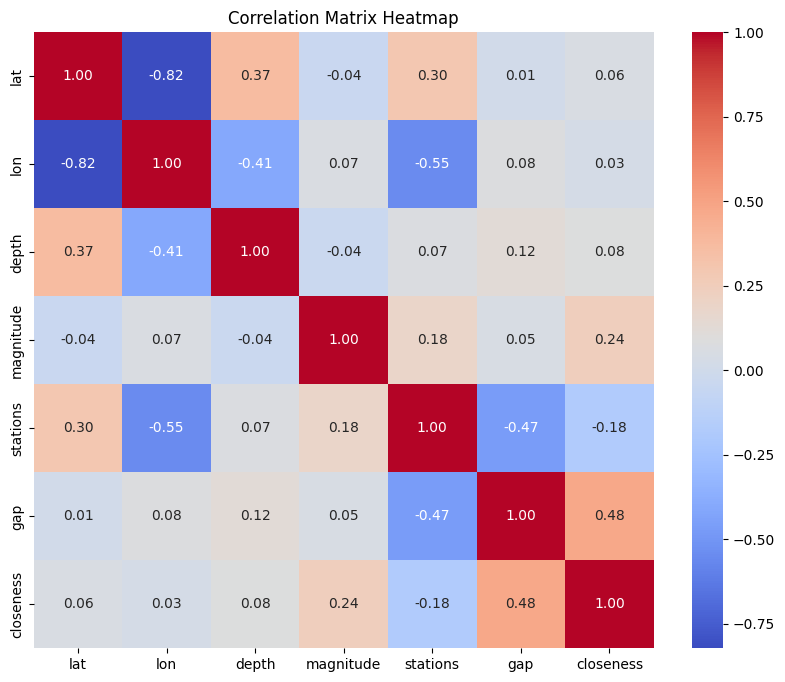

In [73]:
#select numerical features for correlation analysis
numerical_features = ['lat', 'lon', 'depth', 'magnitude', 'stations', 'gap', 'closeness']
correlation_matrix = data[numerical_features].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix heat map shows that there is no strong correlation between the measured earthquake detphs, magnitudes, closeness to the epicenters, etc.

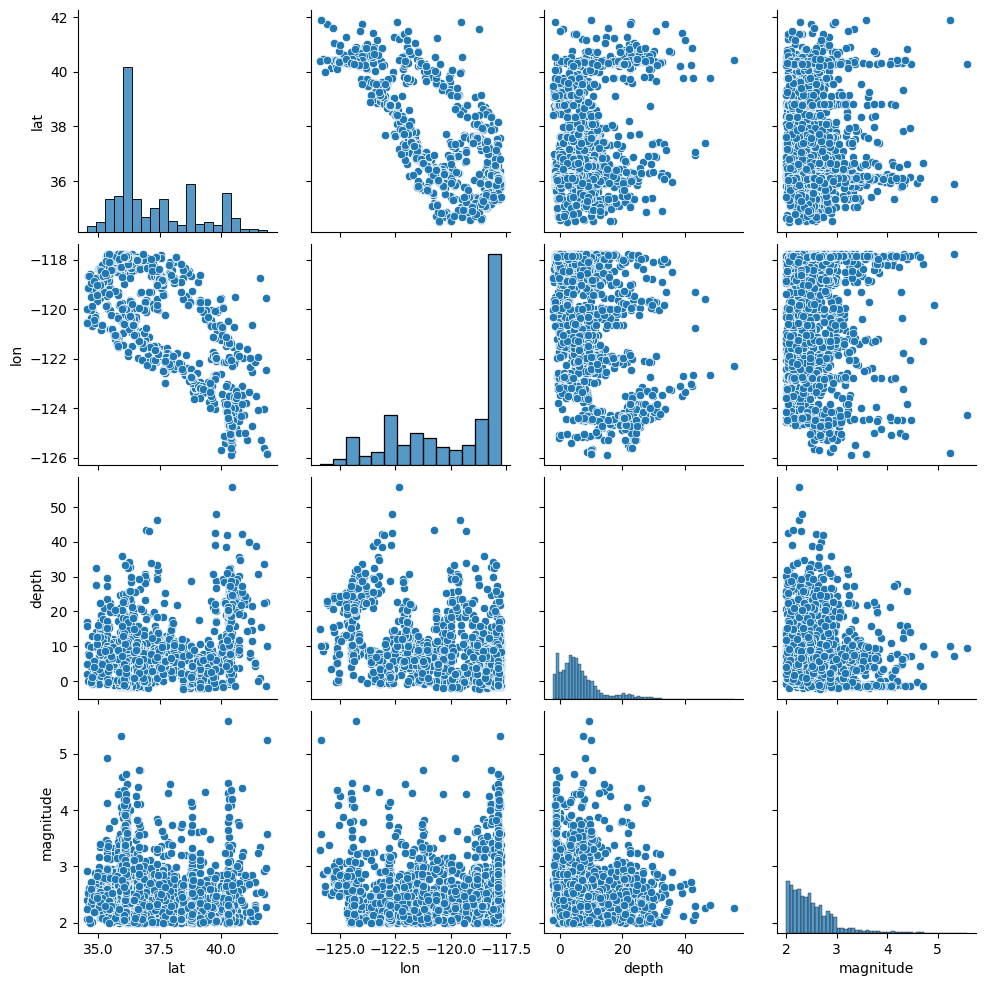

In [74]:
# create the pair plot with key features
key_features = ['lat', 'lon', 'depth', 'magnitude']
sns.pairplot(data[key_features])
plt.show()

<ipython-input-75-b940703bda6b>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['magnitude'], shade=True)


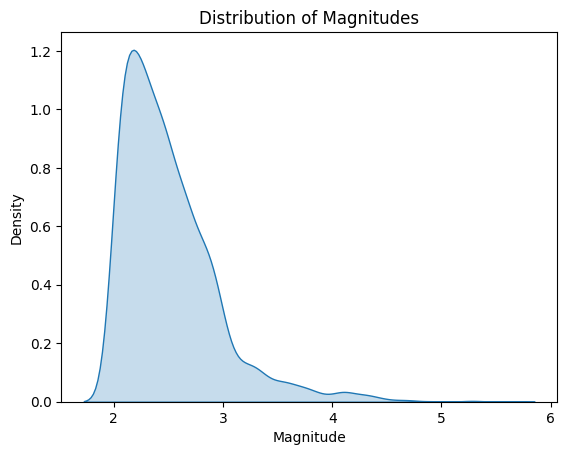

In [75]:
#density plot to show distribution of magnitudes
sns.kdeplot(data['magnitude'], shade=True)
plt.title('Distribution of Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.show()

This graph shows that the data is skewed to the right and that the majority of earthquakes recorded were between a magnitude of 2 and 3.

<ipython-input-76-3ca51a7b4c10>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['depth'], shade=True)


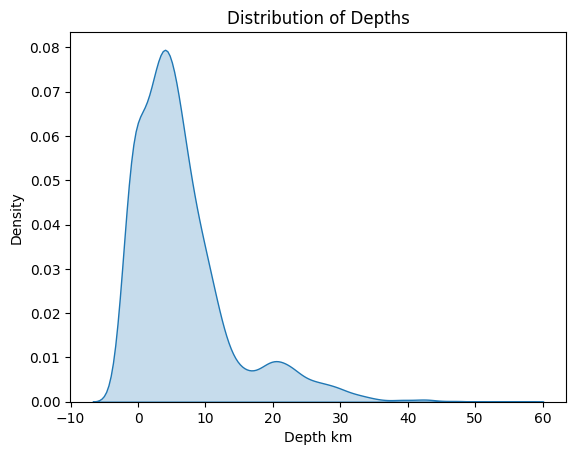

In [76]:
#density plot to show distribution of depths
sns.kdeplot(data['depth'], shade=True)
plt.title('Distribution of Depths')
plt.xlabel('Depth km')
plt.ylabel('Density')
plt.show()

This graph is skewed to the right and shows that the majority of earthquakes recorded occured at a depth between 0 and 10 km deep.

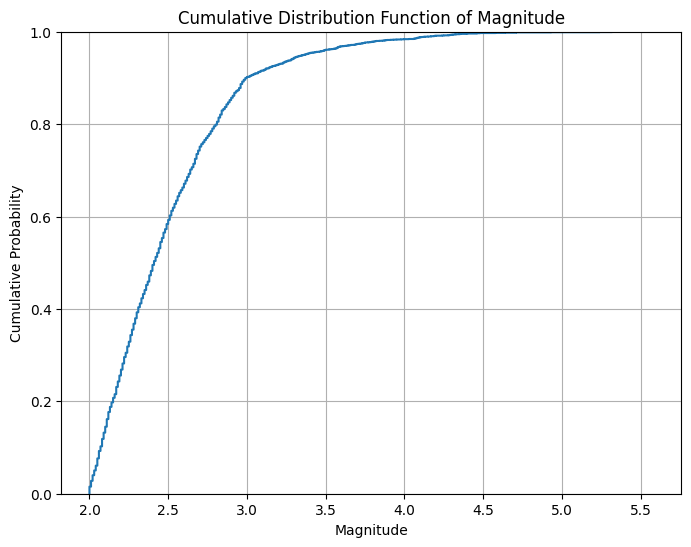

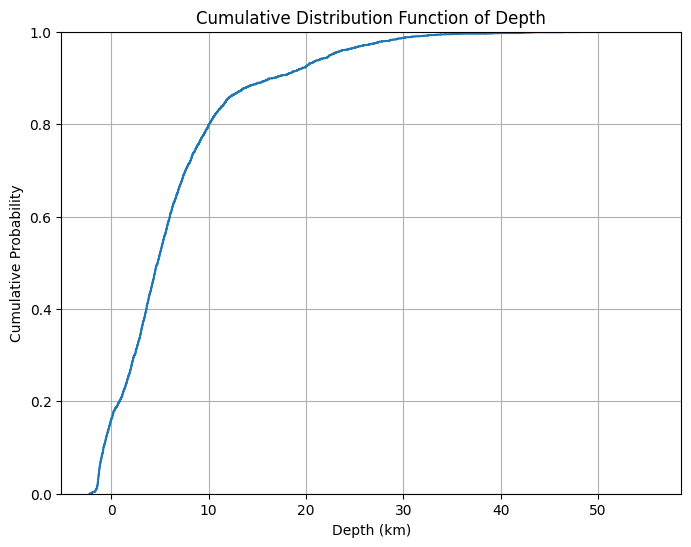

In [77]:
#create the CDF plot for magnitude
plt.figure(figsize=(8, 6))
sns.ecdfplot(data['magnitude'])
plt.title('Cumulative Distribution Function of Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

#create the CDF plot for depth
plt.figure(figsize=(8, 6))
sns.ecdfplot(data['depth'])
plt.title('Cumulative Distribution Function of Depth')
plt.xlabel('Depth (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

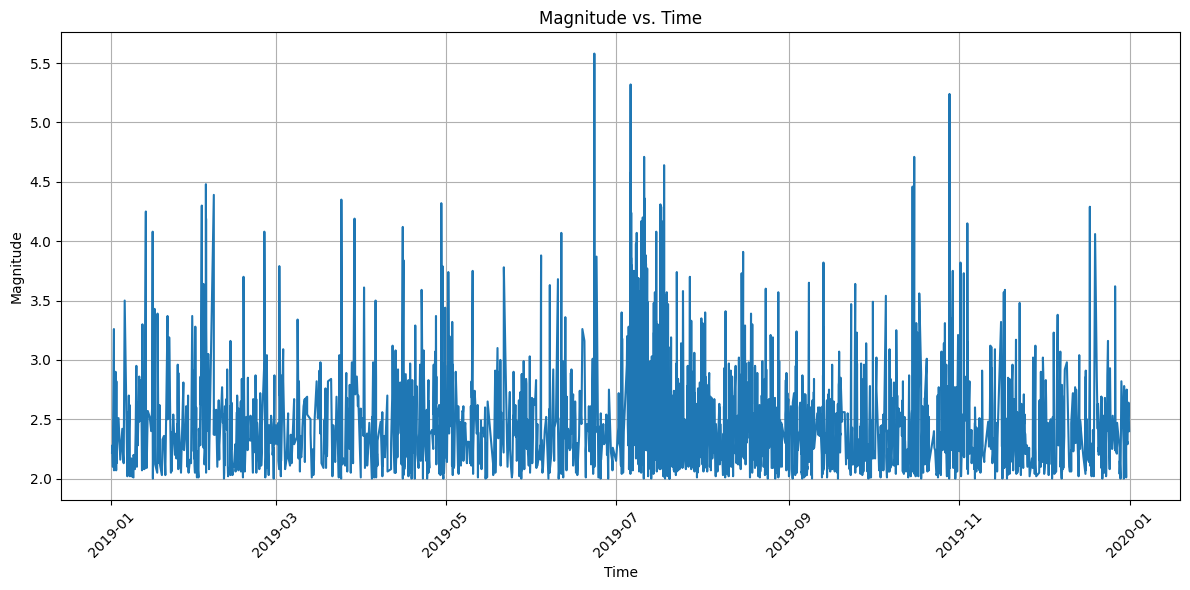

In [78]:
#convert the date and time columns to datetime objects
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

#set the datetime column as the index
data = data.set_index('datetime')

#plot magnitude vs. time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['magnitude'])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Magnitude vs. Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot shows the magnitude of earthquakes over the year 2019. It shows an increase in frequency and magnitude around the month of July.

Moving forward I hope to find if there is any correlation between time passed and likelihood of a repeat event.

# KMeans

Below shows the Kmeans clustering using the elbow method to determine the optimal number of clusters. It is followed by a plot that shows the three determined clusters and how the earthquakes measured in both depth and magnitude.

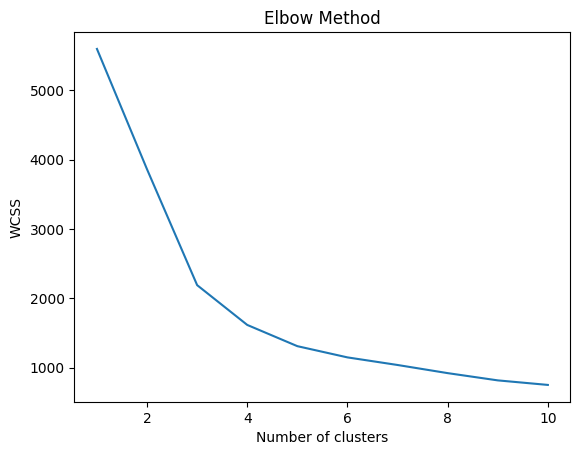

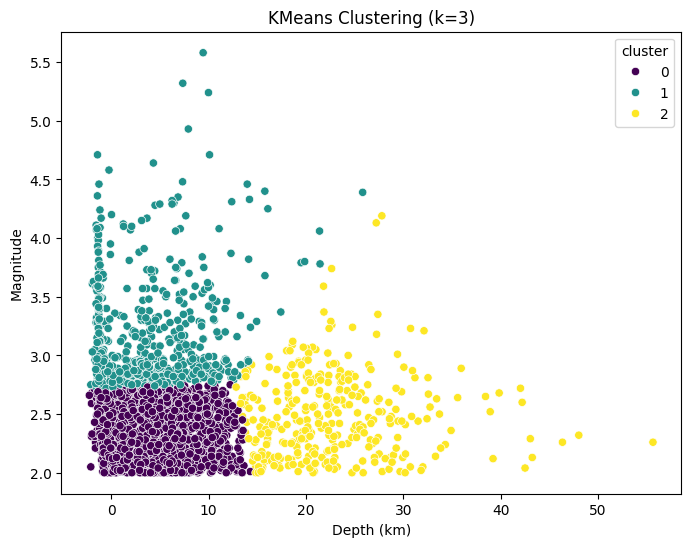

In [79]:
# Select features for clustering
features = ['depth', 'magnitude']
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply KMeans clustering with the chosen number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=data, palette='viridis')
plt.title(f'KMeans Clustering (k={optimal_k})')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

In [80]:
# Calculate Silhouette Score
score = kmeans.score(X_scaled)
print(f"KMeans score: {score}")

KMeans score: -2188.6546202481713


# DBScan

Below shows the DBScan clustering method to determine the optimal number of clusters.

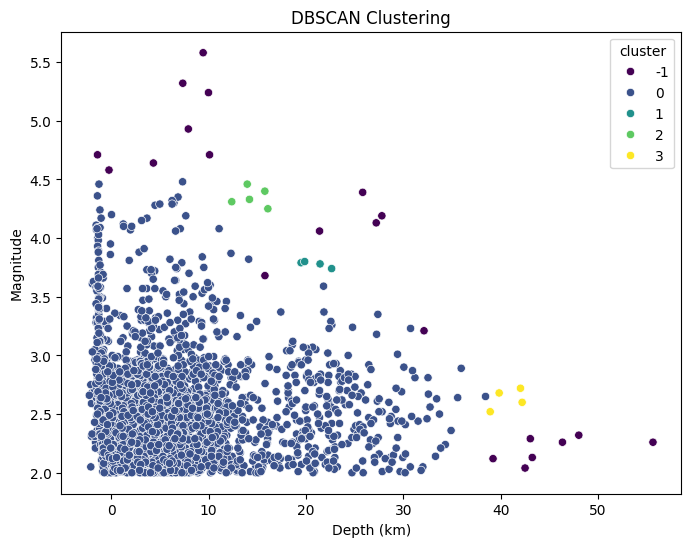

Silhouette Score: 0.5120701767151997


In [81]:
# Select features for clustering
features = ['depth', 'magnitude']
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=data, palette='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

In [82]:
# Get the number of clusters
n_clusters = len(set(data['cluster'])) - (1 if -1 in data['cluster'] else 0) # Subtract 1 for noise points if present

print(f"Number of clusters: {n_clusters}")

Number of clusters: 5


# Gaussian Mixture

Below shows the Gaussian Mixture method of clustering.

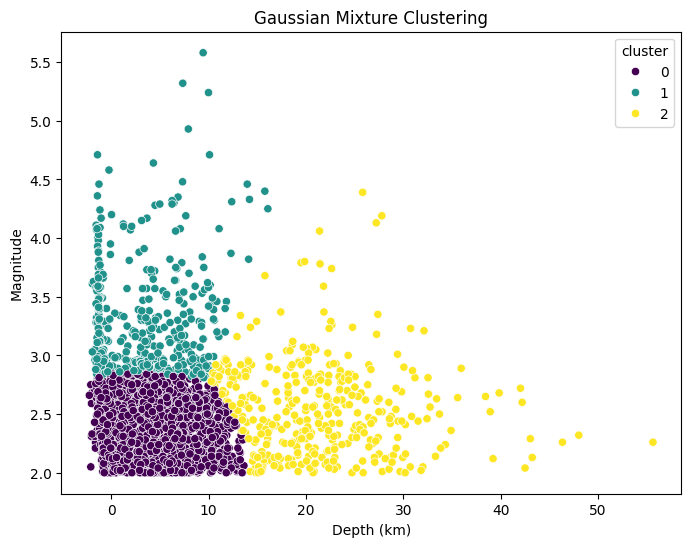

Silhouette Score: 0.4852768622193759


In [83]:
# prompt: apply the gaussian mixture method of clustering the the dataset and score it using the silhouette method

# Select features for clustering
features = ['depth', 'magnitude']
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Gaussian Mixture clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # You can adjust n_components
data['cluster'] = gmm.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=data, palette='viridis')
plt.title('Gaussian Mixture Clustering')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Write up

### Which method did you like the best?

I liked the Guassian Mixture and KMeans method the best as I felt it was visually easier to see the clusters and the culsters chosen made sense to me logically.

### Which method did you like the least?

I did not like the DBScan method as much as the otehr two because I found it vvery difficult to determine how the clusters where formed or even to visually determine where the clusters fell.

### How did you score these unsupervised models?

I used a mixture of kmeans scoring and silhuette scoring. I used the KMeans score on the KMeans clustering which returned a large negative number indicating the clustering was poor. For the DSBcan and the Guassian Mixture I used silhuette scoring both of which returned a score close to 0.5 which falls within the range of a "good" cluster.

### Did the output align with your geologic understanding?

In general the output aligned with my geologic understanding as shallower earthquakes tend to have higher magnitudes and deeper earthquakes have lower magnitudes. This was shown in the clustering of all three methods used.

### What did you want to learn more about?

I would like to learn more about how the methods I used are different from one another as they produced realtively similar models/results. I would like to learn more about if this is due to the nature of my dataset, user error, or if i jsut happened to pick methods that have similar outputs.

### Did you pre-process your data?

I did some light pre-processing of my data, however after running through the unsurpervised models I think I would like to go back to do a little more pre-processing. This dataset does not contain a lot of numerical data, so therefore my features have been limited to depth, magnitude, latitude, and longitude. Moving forward I would try to l=mvoe away from longitude and latitude data and attempt to make a data column relating to time between seismic events to then use that data in my data clustering.

### What was a decision you were most unsure about?

As I am new to unsupervised methods I felt unsure about if I was using the correct methods, features, and if I was using the correct plots to visualize my data. Moving forward I would like to spend more time with the different unsupervised methods inorder learn which method truely works best for my dataset. I would also like to try different types of plots to visualize my clustering methods to determine which plots best show my data.